In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.autolayout"] = True

In [2]:
import torch
from torch import nn, optim
from utils import Legendre_Polynomials, Finite_Elements
import torch.nn.functional as F

## Define the parameters of the equation

In [149]:
# f = lambda x: x ** -.25  # Source function
f = lambda x: 1  # Source function
k = 2. * (np.pi / 2)  # frequency
a, b = -1., +1.  # Domain
ga, gb = 2., 5.  # Values at the boundaries

## Train the neural network

In [206]:
from solvers import VPINN_HelmholtzImpedance

width = 8
depth = 1
activation = F.relu
testfuncs = 8
penalty = None

cuda = False
epochs = 60000
lr = 1e-01
momentum = .2
seed = None
dropout_probs = None

model = VPINN_HelmholtzImpedance(f=f, k=k, a=a, b=b, ga=ga, gb=gb,
                                layers=[1] + [width for _ in range(depth)] + [2],
                                activation=activation,
                                dropout_probs=dropout_probs,
                                penalty=penalty,
                                N_quad=100,
                                seed=seed,
                                cuda=cuda,
                                )

# testfunctions = Legendre_Polynomials(testfuncs - 1, a, b)()
testfunctions = Finite_Elements(testfuncs - 1, a, b, dtype=torch.Tensor)()
if cuda:
  model = model.cuda()
# optimizer = optim.Adam([
#   {'params': model.lins[0].weight, 'lr': 0},
#   {'params': model.lins[0].bias, 'lr': 0},
#   {'params': model.lins[1].weight, 'lr': lr},
#   {'params': model.lins[1].bias, 'lr': 0},
#   ], lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50, min_lr=1e-08, verbose=True)
# losses = model.train_(testfunctions, epochs, optimizer, scheduler)

/home/sepeehr/anaconda3/envs/mcss/lib/python3.9/site-packages/scipy/special/orthogonal.py:139: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


In [ ]:
model.lins[0].bias = nn.Parameter(-1 * torch.tensor([-1, -.75, -.5, -.25, 0, +.25, +.5, +.75]).float())
model.lins[1].weight = nn.Parameter(torch.tensor([
    [+1.25, -.75, -.75, -1, 0., +.75, +1.25, +1],
    [-1.5, -1.5, 0, 1.75, +2.5, +1.75, 0, -1.5]]).float())
model.lins[1].bias = nn.Parameter(torch.tensor([0., +1.]).float())

In [217]:
optimizer = optim.Adam([
  # {'params': model.lins[0].weight, 'lr': 0},
  # {'params': model.lins[0].bias, 'lr': 0},
  {'params': model.lins[1].weight, 'lr': 1e-02},
  {'params': model.lins[1].bias, 'lr': 1e-02},
  ], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-03, min_lr=1e-08, verbose=True)
losses = model.train_(testfunctions, 10000, optimizer, scheduler)
# for p in model.lins[1].parameters(): print(1)

Epoch 000000 / 100: loss = 4.38e+00
Epoch 000100 / 100: loss = 1.77e+00


## Plot the parameters

In [218]:
for n, p in model.named_parameters():
    print(n, p)

lins.0.weight Parameter containing:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], requires_grad=True)
lins.0.bias Parameter containing:
tensor([ 1.0000,  0.7500,  0.5000,  0.2500, -0.0000, -0.2500, -0.5000, -0.7500],
       requires_grad=True)
lins.1.weight Parameter containing:
tensor([[ 0.8228, -0.8420, -0.6085, -0.6297,  0.3801,  0.9241,  1.3832,  1.0097],
        [-1.2815, -1.2339,  0.0775,  1.4243,  1.8666,  1.0612,  0.0179, -0.0216]],
       requires_grad=True)
lins.1.bias Parameter containing:
tensor([-0.0047,  0.7450], requires_grad=True)


Last layer bias: Parameter containing:
tensor([0., 1.], requires_grad=True)


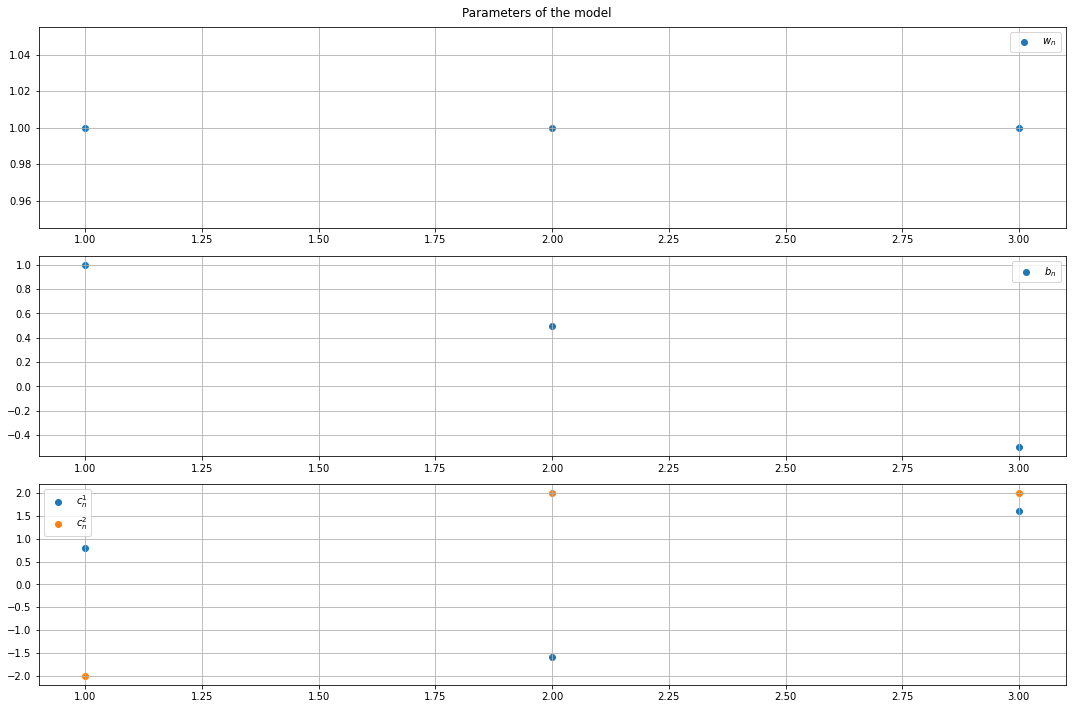

In [176]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=4.0)
fig.suptitle(f'Parameters of the model')

axs[0].scatter(np.arange(1, width + 1), model.lins[0].weight.detach().view(-1).numpy(), label='$w_n$')
axs[1].scatter(np.arange(1, width + 1), model.lins[0].bias.detach().view(-1).numpy(), label='$b_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[0].detach().view(-1).numpy(), label='$c^1_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[1].detach().view(-1).numpy(), label='$c^2_n$')
for ax in axs:
    ax.grid()
    ax.legend()

print(f'Last layer bias: {model.lins[1].bias}')

## Evaluate the results

In [221]:
from solvers import Exact_HelmholtzImpedance_const
u, u_x = Exact_HelmholtzImpedance_const(f(0), k, a, b, ga, gb)

In [256]:
roots, weights = model.roots, model.weights
# model(roots).shape
err_re = u(roots.detach().view(-1).numpy()).real - model(roots)[:, 0].detach().numpy()
np.power(err_re, 2)
# model(roots)[:, 0].detach().numpy().shape
# u(roots.detach().view(-1).numpy()).real.shape

array([3.06282239e-03, 3.11863772e-03, 3.25171859e-03, 3.46595095e-03,
       3.76792136e-03, 4.16629622e-03, 4.67153313e-03, 5.29541634e-03,
       6.05044607e-03, 6.94908854e-03, 8.00276082e-03, 9.22063831e-03,
       1.06082568e-02, 1.21658938e-02, 1.38867637e-02, 1.57551635e-02,
       1.77445523e-02, 1.98159795e-02, 2.19165329e-02, 2.39787269e-02,
       2.59205252e-02, 2.76464429e-02, 2.90501099e-02, 3.22563685e-02,
       3.95723358e-02, 4.70815152e-02, 5.45087792e-02, 6.15516342e-02,
       6.78922161e-02, 7.32123554e-02, 7.72105753e-02, 7.96207488e-02,
       8.02316964e-02, 7.96808004e-02, 8.59287679e-02, 9.03270319e-02,
       9.26593393e-02, 9.28106084e-02, 9.07747895e-02, 8.66567791e-02,
       8.06674287e-02, 7.31117204e-02, 6.93843886e-02, 6.93594292e-02,
       6.81224316e-02, 6.58887252e-02, 6.29067346e-02, 5.94397262e-02,
       5.57486154e-02, 5.20780794e-02, 4.60361615e-02, 3.82800587e-02,
       3.16689424e-02, 2.62204837e-02, 2.18998808e-02, 1.86380036e-02,
      

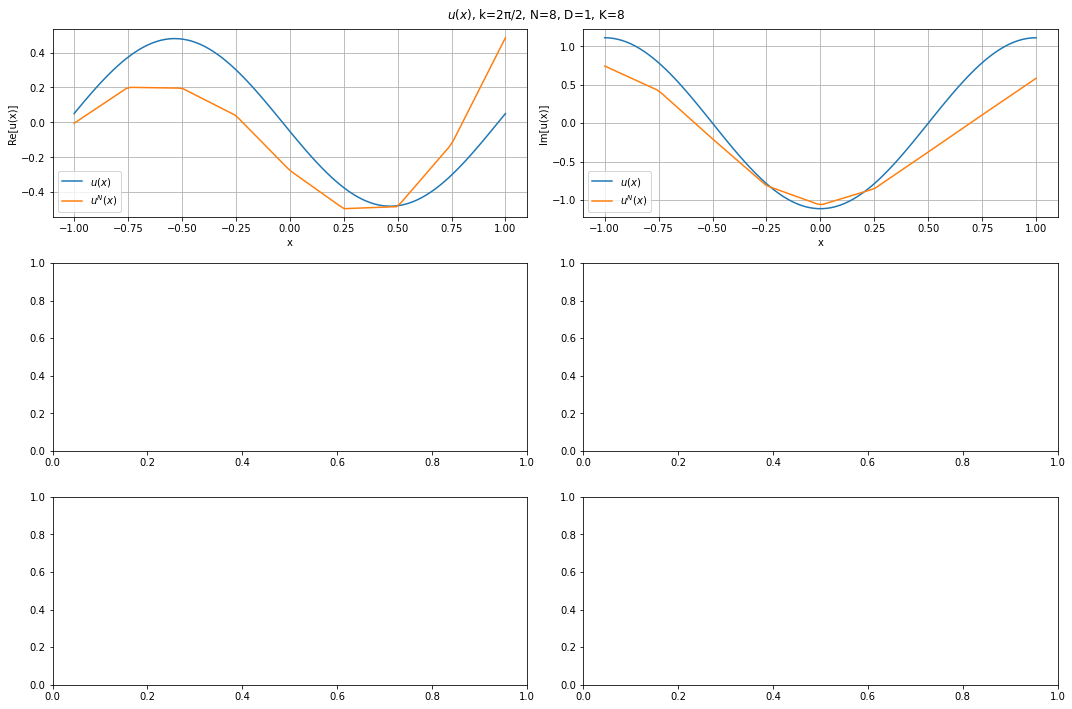

In [219]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u(xpts).real, u(xpts).imag
rpts_re, rpts_im = model.deriv(0, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts.real, yerr=upts.real - rpts.real, ecolor='black', label='$u(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts.imag, yerr=upts.imag - rpts.imag, ecolor='black', label='$u(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

# axs[2, 0].plot(xpts, upts.real - rpts.real)
# axs[2, 0].set(xlabel='x', ylabel='$Re[u(x)-u^N(x)]$')
# axs[2, 0].grid()
# axs[2, 1].plot(xpts, upts.imag - rpts.imag)
# axs[2, 1].set(xlabel='x', ylabel='$Im[u(x)-u^N(x)]$')
# axs[2, 1].grid()

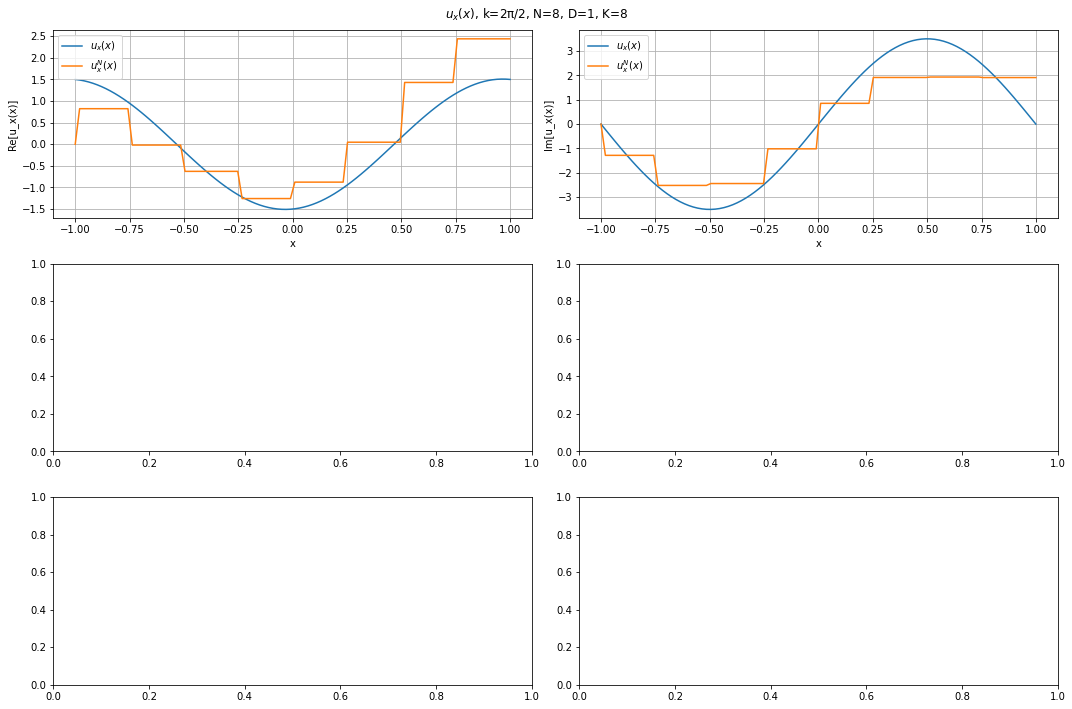

In [220]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u_x(xpts).real, u_x(xpts).imag
xpts.requires_grad_()
rpts_re, rpts_im = model.deriv(1, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u_x(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u_x(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N_x(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u_x(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N_x(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts.real, yerr=upts.real - rpts.real, ecolor='black', label='$u_x(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts.imag, yerr=upts.imag - rpts.imag, ecolor='black', label='$u_x(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

# axs[2, 0].plot(xpts, upts.real - rpts.real)
# axs[2, 0].set(xlabel='x', ylabel='$Re[u_x(x)-u^N_x(x)]$')
# axs[2, 0].grid()
# axs[2, 1].plot(xpts, upts.imag - rpts.imag)
# axs[2, 1].set(xlabel='x', ylabel='$Im[u_x(x)-u^N_x(x)]$')
# axs[2, 1].grid()